# Image Classification by MobileNetV2

The classification example is implemeted by MobileNetV2.

Here is a link of dataset: https://www.kaggle.com/ahmetsamiyenieri/imageclassification

## Content

<ul>
  <li><a href="#part1">1. Import libraries</a></li>
  <li><a href="#part2">2. Define the main directory of images' folders</a></li>
  <li><a href="#part3">3. Define dataframe which is involved in image's filepath and its label</a></li>
  <li><a href="#part4">4. Split dataframe into test and train</a></li>
  <li><a href="#part5">5. Define test and train generator processed by MobileNetV2</a></li>    
  <li><a href="#part6">6. Define the size of image</a></li>
  <li><a href="#part7">7. Define images by train, test and lastly validation</a></li>
  <li><a href="#part8">8. Define MobileNetV2 Model</a></li>
  <li><a href="#part9">9. Fit Model</a></li>
  <li><a href="#part10">10. Draw Confusion Matrix and Show Classification Result Report</a></li>  
</ul>

<a id='part1'></a>
## 1 ) Import libraries

In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

<a id='part2'></a>
## 2 ) Define the main directory of images' folders 

In [18]:
# data/train , data/test
image_dir = Path('data')

<a id='part3'></a>
## 3 ) Define dataframe which is involved in image's filepath and its label

In [19]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df['Label'].value_counts()

violin            600
guitar            600
org               599
mug               599
mobile phone      598
remote control    598
laptop            597
chair             593
pot               592
slipper           592
Name: Label, dtype: int64

In [20]:
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    #samples.append(category_slice.sample(400, random_state=1,replace=True))
    samples.append(category_slice)
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

image_df['Label'].value_counts()

violin            600
guitar            600
org               599
mug               599
mobile phone      598
remote control    598
laptop            597
chair             593
pot               592
slipper           592
Name: Label, dtype: int64

In [21]:
image_df

,Filepath,Label
0,data\train\train\org\org (333).jpg,org
1,data\train\train\org\org (197).jpg,org
2,data\train\train\org\org_download (77).jpg,org
3,data\train\train\pot\pot_download (72).jpg,pot
4,data\train\train\chair\chair (326).jpg,chair
...,...,...
5963,data\train\train\guitar\guitar (293).jpg,guitar
5964,data\train\train\slipper\slipper (401).jpg,slipper
5965,data\train\train\pot\pot (377).jpg,pot
5966,data\train\train\chair\chair (218).jpg,chair


<a id='part4'></a>
## 4 ) Split dataframe into test and train 

In [22]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

<a id='part5'></a>
## 5 ) Define test and train generator processed by MobileNetV2

In [23]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

<a id='part6'></a>
## 6 ) Define the size of image

In [24]:
IMAGE_SIZE = 128

<a id='part7'></a>
## 7 ) Define images by train, test and lastly validation

In [25]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3342 validated image filenames belonging to 10 classes.
Found 835 validated image filenames belonging to 10 classes.
Found 1791 validated image filenames belonging to 10 classes.


<a id='part8'></a>
## 8 ) Define MobileNetV2 Model

In [26]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False 

In [27]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


<a id='part9'></a>
## 9 ) Fit Model

In [28]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 280s 3s/step - loss: 0.9066 - accuracy: 0.7184 - val_loss: 0.0599 - val_accuracy: 0.9820
Epoch 2/100
105/105 [==============================] - 196s 2s/step - loss: 0.0290 - accuracy: 0.9921 - val_loss: 0.0405 - val_accuracy: 0.9856
Epoch 3/100
105/105 [==============================] - 146s 1s/step - loss: 0.0094 - accuracy: 0.9983 - val_loss: 0.0238 - val_accuracy: 0.9916
Epoch 4/100
105/105 [==============================] - 147s 1s/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0157 - val_accuracy: 0.9904
Epoch 5/100
105/105 [==============================] - 147s 1s/step - loss: 5.3501e-04 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9952
Epoch 6/100
105/105 [==============================] - 147s 1s/step - loss: 4.6638e-04 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9940
Epoch 7/100
105/105 [==============================] - 149s 1s/step - loss: 3.1885e-04 - accuracy: 1.0000 - val_loss: 0.0157 - v

<a id='part10'></a>
## 10 ) Draw Confusion Matrix and Show Classification Result Report 

Test Accuracy: 98.44%


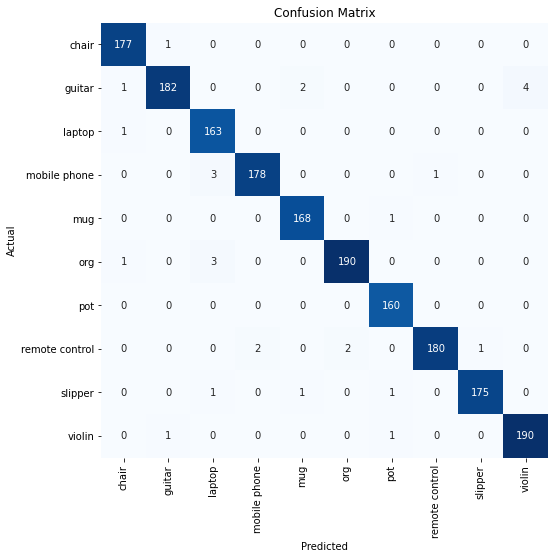

Classification Report:
----------------------
                 precision    recall  f1-score   support

         chair       0.98      0.99      0.99       178
        guitar       0.99      0.96      0.98       189
        laptop       0.96      0.99      0.98       164
  mobile phone       0.99      0.98      0.98       182
           mug       0.98      0.99      0.99       169
           org       0.99      0.98      0.98       194
           pot       0.98      1.00      0.99       160
remote control       0.99      0.97      0.98       185
       slipper       0.99      0.98      0.99       178
        violin       0.98      0.99      0.98       192

      accuracy                           0.98      1791
     macro avg       0.98      0.98      0.98      1791
  weighted avg       0.98      0.98      0.98      1791



In [29]:
results = model.evaluate(test_images, verbose=0)
predictions = np.argmax(model.predict(test_images), axis=1)

class_names = list(test_images.class_indices.keys())

cm = confusion_matrix(test_images.labels, predictions, labels=np.arange(10))
clr = classification_report(test_images.labels, predictions, labels=np.arange(10), target_names=class_names)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(10) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(10) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)